# Trade-offs between risk differentiation and capital optimization

This code generates the results for the paper that can be be found [here](https://github.com/orioldemarcos/CreditRisk/blob/a62d3cfe3c5c14bdc06c505d9bab344c7004deb5/Trade%20off%20paper%20vF.pdf).

In [1]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandasql as ps

Defining the functions for capital requirements (K) and Information Value (IV).

In [2]:
def calculate_k(pd, lgd=0.5, m=2.5):
    """
    Calculate the capital requirement/risk weight.

    Parameters:
    pd (float): Probability of default.
    lgd (float, optional): Loss given default. Default is 0.5.
    m (float, optional): Maturity. Default is 2.5.

    Returns:
    float: Capital requirement/risk weight.
    """
    # Correlation r
    r = 0.12 * (1 - math.exp(-50 * pd)) / (1 - math.exp(-50)) + 0.24 * (1 - (1 - math.exp(-50 * pd)) / (1 - math.exp(-50)))

    # Maturity adjustment b
    b = (0.11852 - 0.05478 * math.log(pd)) ** 2
    
    term1 = lgd * norm.cdf((norm.ppf(pd)/math.sqrt(1-r)) + (math.sqrt(r/(1-r)))*norm.ppf(0.999)) - pd * lgd
    term2 = (1 + (m - 2.5) * b) / (1 - 1.5 * b)
    
    return term1 * term2

#Vectorize
calculate_k_v = np.vectorize(calculate_k)


def calculate_iv(pd_vector):
    """
    Calculate the Informatio Value (IV).

    Parameters:
    pd_vector (array-like): A sequence containing the probabilities of default.

    Returns:
    float: IV.
    """
    n_buckets = len(pd_vector)
    pd_agg = np.mean(pd_vector)
    IV = 0

    for pd in pd_vector:
        #Under a unif. distribution
        share_of_goods = (1/n_buckets)*(1-pd)/(1-pd_agg)
        share_of_bads = (1/n_buckets)*pd/pd_agg
        WOE = np.log(share_of_goods) - np.log(share_of_bads)
        IV += (share_of_goods-share_of_bads)*WOE

    return IV

What is its maximum of the risk weight function?

In [4]:
df_pd = pd.DataFrame({
    'PD': np.tile(np.linspace(0.0001, 1, 2500), len(LGD_values)),
    'LGD': np.repeat(LGD_values, 2500)
})

df_pd['K'] = calculate_k_v(pd=df_pd['PD'], lgd=df_pd['LGD'])

LGD_values = [0.1, 0.3,  0.5,  0.7, 0.9]

for LGD_value, df_filtered in df_pd.groupby('LGD'):
    index_of_max_K = df_filtered['K'].idxmax()
    PD_maximizer = round(df_filtered.loc[index_of_max_K, 'PD'],2)
    print(f"For LGD={LGD_value}, PD that maximizes K is {PD_maximizer}")

For LGD=0.1, PD that maximizes K is 0.3
For LGD=0.3, PD that maximizes K is 0.3
For LGD=0.5, PD that maximizes K is 0.3
For LGD=0.7, PD that maximizes K is 0.3
For LGD=0.9, PD that maximizes K is 0.3


 The following code generates Figure 1.

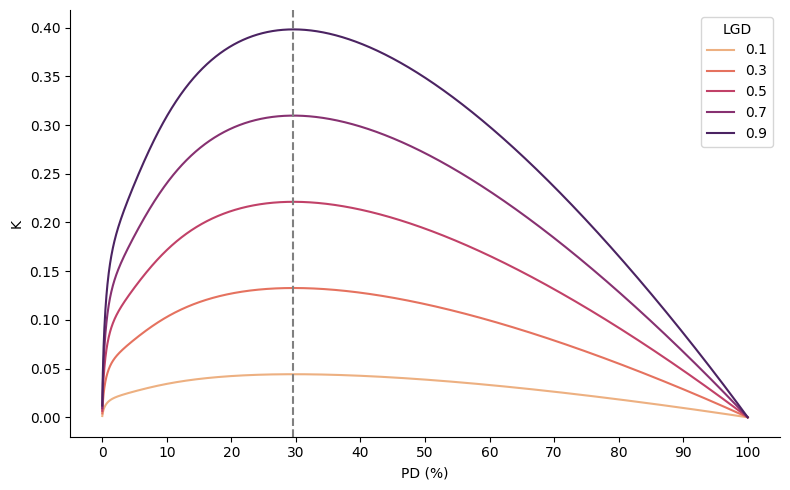

In [5]:
df_pd['PD'] *= 100

# Create a maroon color palette
palette = sns.color_palette("flare",as_cmap=True)
#palette = palette[:int(0.8 * len(palette))]

# Create the plot
fig, ax2 = plt.subplots(figsize=(8, 5))

# Use the maroon palette in lineplot
sns.lineplot(data=df_pd, x='PD', y='K', hue='LGD', palette=palette, legend='full', ax=ax2)

ax2.set_xlabel('PD (%)')
ax2.set_ylabel('K')
ax2.set_xticks(np.arange(0, df_pd['PD'].max() + 10, 10))
ax2.axvline(x=29.6, color='gray', linestyle='--')  # Highlight the maximum

# Remove top and right spines
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()

The following code generates Figure 3.

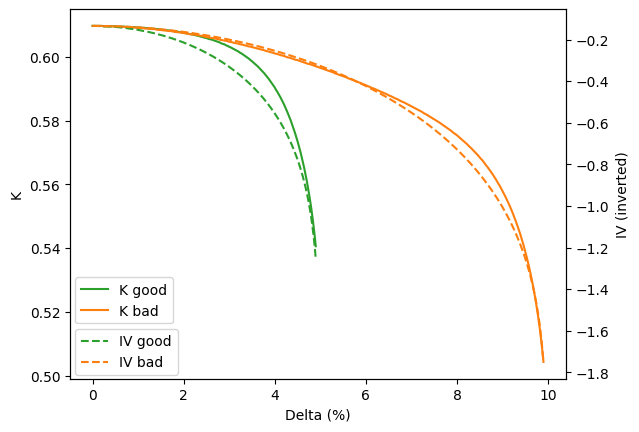

In [142]:
pd_good = 0.05
pd_bad = 0.1

delta_good = np.linspace(0, pd_good-0.001, 250)
delta_bad = np.linspace(0, pd_bad-0.001, 250)

# Pre-allocate DataFrames
df_good = pd.DataFrame({'Delta': delta_good, 'K': np.nan, 'IV': np.nan})
df_bad = pd.DataFrame({'Delta': delta_bad, 'K': np.nan, 'IV': np.nan})

# Calculate values for good scenario
for i, delta in enumerate(delta_good):
    pd_values_good = [pd_good-delta, pd_good+delta, pd_bad, pd_bad]
    df_good.at[i, 'K'] = round(sum(calculate_k_v(pd_values_good)), 4)
    df_good.at[i, 'IV'] = round(calculate_iv(pd_values_good), 4)

# Calculate values for bad scenario
for i, delta in enumerate(delta_bad):
    pd_values_bad = [pd_good, pd_good, pd_bad-delta, pd_bad+delta]
    df_bad.at[i, 'K'] = round(sum(calculate_k_v(pd_values_bad)), 4)
    df_bad.at[i, 'IV'] = round(calculate_iv(pd_values_bad), 4)

# Convert Delta to percentage
df_good['Delta'] *= 100
df_bad['Delta'] *= 100

# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plotting K values for good and bad scenarios
sns.lineplot(x='Delta', y='K', data=df_good, ax=ax1, color='#2ca02c', label='K good')
sns.lineplot(x='Delta', y='K', data=df_bad, ax=ax1, color='#ff7f0e', label='K bad')
ax1.set_xlabel('Delta (%)')
ax1.set_ylabel('K')

# Create a secondary y-axis for IV values and plot negative values to invert the axis
ax2 = ax1.twinx()
ax2.plot(df_good['Delta'], -df_good['IV'], color='#2ca02c', linestyle='--', label='IV good')
ax2.plot(df_bad['Delta'], -df_bad['IV'], color='#ff7f0e', linestyle='--', label='IV bad')
ax2.set_ylabel('IV (inverted)')

# Location of legends
ax1.legend(loc='lower left', bbox_to_anchor=(0.01, 0.15), borderaxespad=0.)
ax2.legend(loc='lower left', bbox_to_anchor=(0.01, 0.01), borderaxespad=0.)

# Show the plot
plt.show()

Defining the function that matches segmentations with the same IV.

In [6]:
def generate_filtered_result(pd_good, pd_bad):
    """
    Generate a DataFrame pairing good and bad segmentations with equal IV.

    Parameters:
    pd_good, pd_bad.

    Returns:
    DataFrame: result.
    """
    # Create separate Delta arrays for good and bad scenarios
    delta_good = np.linspace(0, min(pd_good - 0.001, 0.2961 - pd_good), 500)
    delta_bad = np.linspace(0, min(pd_bad - 0.001, 0.2961 - pd_bad), 500)

    # Initialize DataFrame
    df_good = pd.DataFrame({'Delta': delta_good, 'K': np.nan, 'IV': np.nan})
    df_bad = pd.DataFrame({'Delta': delta_bad, 'K': np.nan, 'IV': np.nan})

    # Calculate values for good scenario
    for i, delta in enumerate(delta_good):
        pd_values_good = [pd_good-delta, pd_good+delta, pd_bad, pd_bad]
        df_good.at[i, 'K'] = round(sum(calculate_k_v(pd_values_good)), 4)
        df_good.at[i, 'IV'] = round(calculate_iv(pd_values_good), 4)

    # Calculate values for bad scenario
    for i, delta in enumerate(delta_bad):
        pd_values_bad = [pd_good, pd_good, pd_bad-delta, pd_bad+delta]
        df_bad.at[i, 'K'] = round(sum(calculate_k_v(pd_values_bad)), 4)
        df_bad.at[i, 'IV'] = round(calculate_iv(pd_values_bad), 4)

    # SQL query to match IV values
    query = """
    SELECT 
        t1.*,
        t2.Delta as Delta_bad,
        t2.K AS K_bad,
        t2.IV AS IV_bad,
        100*(t1.K / t2.K-1) as K_ratio,
        100*(t1.IV / t2.IV-1) as IV_ratio
    FROM 
        df_good AS t1
    INNER JOIN 
        df_bad AS t2
    ON 
        round(t1.IV,6) = round(t2.IV, 6) AND
        t1.Delta < t2.Delta
    """

    # Execute SQL query
    result = ps.sqldf(query, locals())

    return result

The following code generates Figure 5.

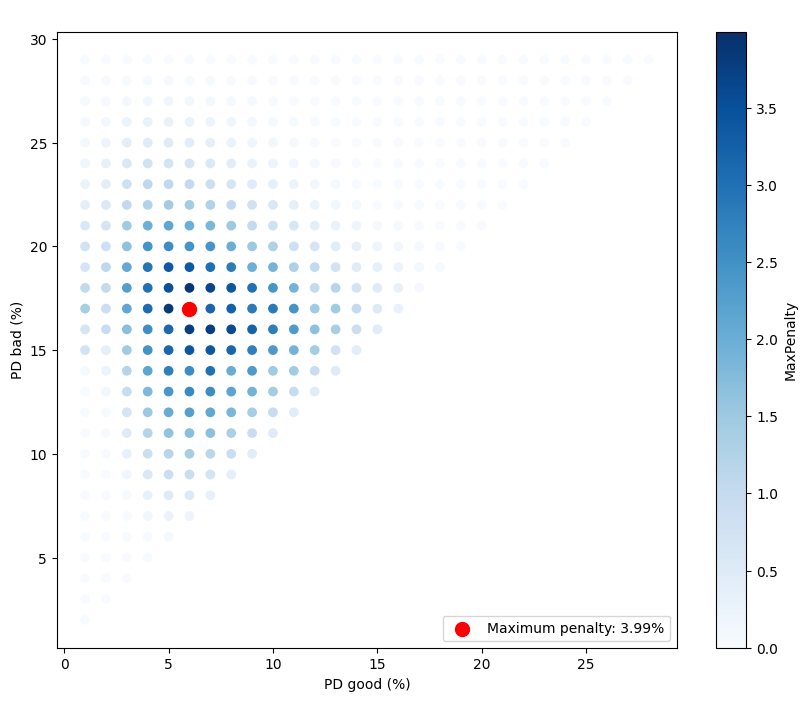

In [7]:
pd_range = np.round(np.linspace(0.01, 0.29, 29),2)
# Initialise list
results = []

for pd_good in pd_range:
    for pd_bad in pd_range:
        if pd_good < pd_bad:
            # First, generate the filtered result for the current pd_good and pd_bad
            result = generate_filtered_result(pd_good, pd_bad)

            # Then calculate the max K ratio from the filtered result
            max_k_ratio = result["K_ratio"].max()

            # Append the result to the list
            results.append({'pd_good': pd_good, 'pd_bad': pd_bad, 'max_k_ratio': max_k_ratio})

# Convert the list of dictionaries to a DataFrame
df_results = pd.DataFrame(results)

df_results["pd_good_p"] = 100*df_results["pd_good"]
df_results["pd_bad_p"] = 100*df_results["pd_bad"]

# Plot
plt.figure(figsize=(10, 8))

# Find the most negative min_k_ratio to set as vmin
vmax_value = df_results['max_k_ratio'].max()

# Use the reversed Blues colormap
cmap_reversed = mpl.colormaps['Blues']

scatter = plt.scatter(x=df_results['pd_good_p'], y=df_results['pd_bad_p'], c=df_results['max_k_ratio'], cmap=cmap_reversed, vmax=vmax_value, vmin=0)
plt.colorbar(scatter, label='MaxPenalty')
plt.xlabel('PD good (%)')
plt.ylabel('PD bad (%)')
plt.title(' ')

# Find the minimum min_k_ratio and its corresponding pd_good and pd_bad
max_k_ratio_row = df_results.loc[df_results['max_k_ratio'].idxmax()]
max_pd_good = max_k_ratio_row['pd_good_p']
max_pd_bad = max_k_ratio_row['pd_bad_p']
max_max_k_ratio = max_k_ratio_row['max_k_ratio']

# Plot the minimum min_k_ratio as a red dot
plt.scatter(max_pd_good, max_pd_bad, color='red', s=100, label=f'Maximum penalty: {max_max_k_ratio:.2f}%')
plt.legend()

plt.show()


The following code informs Table 1.

In [111]:
df_test = generate_filtered_result(max_pd_good/100, max_pd_bad/100)
df_test.loc[df_test["K_ratio"].idxmax()]

Delta        0.050251
K            0.667000
IV           0.790600
Delta_bad    0.116244
K_bad        0.641400
IV_bad       0.790600
K_ratio      3.991269
IV_ratio     0.000000
Name: 128, dtype: float64